# test code for cancer KZFP figure: figure 4 for KZFP review paper:
- load softwares needed
- download files needed
- plot the location of cancer related KZFPs on chromosomes

KZFP genes loaded (oncogene/TSG): 18
Saved: /Users/qwan/githubRepo/KZFP_review/outputs/cancer_KZFP_loci.pdf
Saved: /Users/qwan/githubRepo/KZFP_review/outputs/cancer_KZFP_loci.svg


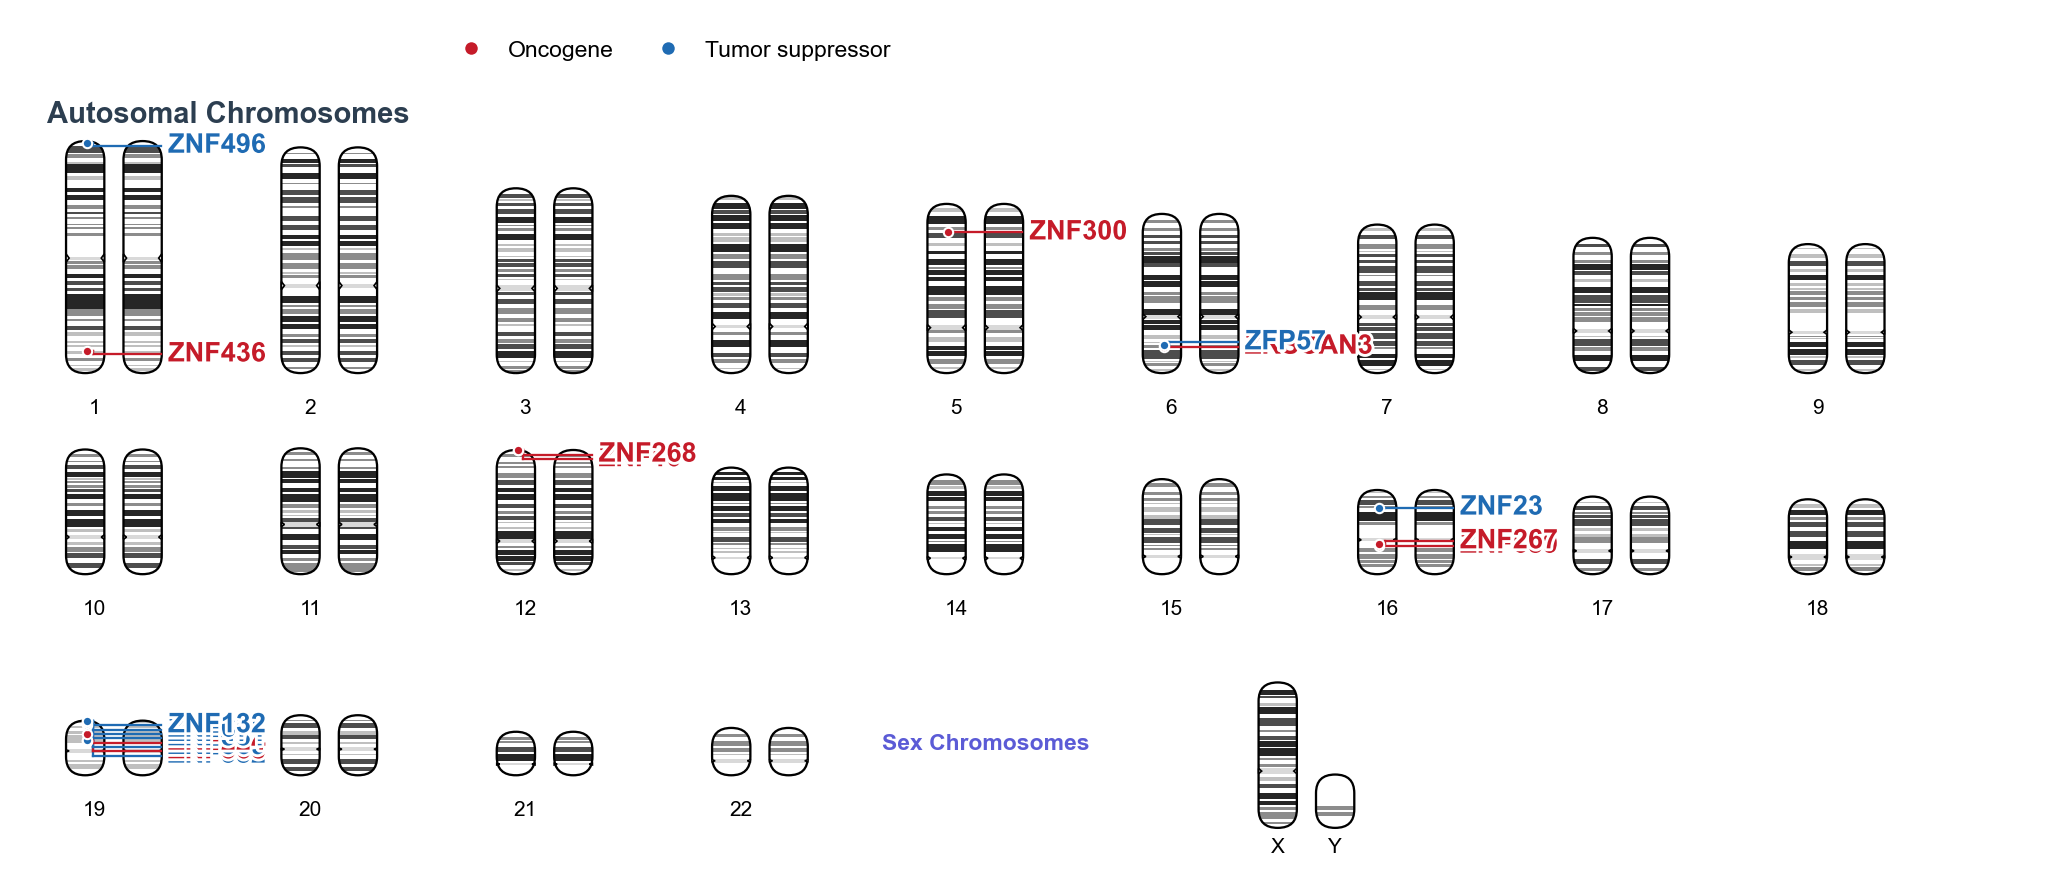

In [137]:
# ============================================
# Nature-style Karyotype with KZFP (oncogene/TSG only)
# FINAL v4 — robust vertical stacking in columns
# ============================================

import os, re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import matplotlib.patheffects as pe

# --------- PATHS ---------
CYTO_PATH = os.path.expanduser("~/githubRepo/KZFP_review/input_data/hg38_cytoBand.txt")
KZFP_BED  = os.path.expanduser("~/githubRepo/KZFP_review/input_data/kzfps_hg38_cancer_geneCoordinates.bed")
BED_IS_ONE_BASED = False

# --------- LOOK & LAYOUT ---------
SEX_TYPE         = "XY"
SCALE_BY_LENGTH  = True
SEX_PANEL_BG     = False
SAVE_DIR         = os.path.expanduser("~/githubRepo/KZFP_review/outputs")
FIG_NAME         = "cancer_KZFP_loci"

# Page/layout
H_MAX  = 1.50
W      = 0.24
GAP    = 0.12
XSTEP  = 1.35
YSTEP  = 1.30
TITLE_FONT = 14

# Label styling
LABEL_FONT   = 13
LABEL_WEIGHT = "bold"
DOT_SIZE     = 4.5
TEXT_OUTLINE = [pe.Stroke(linewidth=2.8, foreground="white"), pe.Normal()]

# Colors
COLOR_ONCO = "#C51B29"
COLOR_TSG  = "#1F6BB3"

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial","DejaVu Sans","Noto Sans CJK SC","Microsoft YaHei","PingFang SC"],
    "figure.dpi": 150,
    "savefig.dpi": 600,
    "savefig.bbox": "tight",
})

# --------- LOADERS ---------
def load_cyto(path):
    return pd.read_csv(path, sep="\t", header=None,
                       names=["chrom","start","end","name","gieStain"])

def load_kzfp_with_group(path, one_based=False):
    df = pd.read_csv(path, sep=r"\s+", header=None)
    # normalize columns
    if df.shape[1] >= 7:
        df = df.iloc[:, :7]; df.columns = ["chrom","start","end","name","score","strand","group"]
    elif df.shape[1] >= 6:
        df = df.iloc[:, :6]; df.columns = ["chrom","start","end","name","score","strand"]; df["group"]=""
    elif df.shape[1] >= 4:
        df = df.iloc[:, :4]; df.columns = ["chrom","start","end","name"]; df["score"]=0; df["strand"]="."; df["group"]=""
    else:
        df = df.iloc[:, :3]; df.columns = ["chrom","start","end"]; df["name"]=""; df["score"]=0; df["strand"]="."; df["group"]=""

    df = df[df["chrom"].str.startswith("chr")].copy()
    df["start"]=df["start"].astype(int); df["end"]=df["end"].astype(int)
    if one_based: df["start"] -= 1
    df["mid"] = ((df["start"]+df["end"])//2).astype(int)

    role_map = {
        "oncogene":"oncogene", "onco":"oncogene", "og":"oncogene",
        "repressor":"tsg", "tsg":"tsg",
        "tumor_suppressor":"tsg", "tumor-suppressor":"tsg", "tumor suppressor":"tsg"
    }
    df["role"] = df["group"].astype(str).str.strip().str.lower().map(role_map)
    df = df[df["role"].isin(["oncogene","tsg"])].copy()
    return df

cyto = load_cyto(CYTO_PATH)
chrom_size = cyto.groupby("chrom")["end"].max().to_dict()
ALL_CHROMS = [f"chr{i}" for i in range(1,23)] + ["chrX","chrY"]
ALL_CHROMS = [c for c in ALL_CHROMS if c in chrom_size]

kzfp = load_kzfp_with_group(KZFP_BED, BED_IS_ONE_BASED)
kzfp = kzfp[kzfp["chrom"].isin(ALL_CHROMS)].copy()
print("KZFP genes loaded (oncogene/TSG):", len(kzfp))

# --------- HELPERS ---------
def subbands(chrom):
    return cyto.loc[cyto["chrom"].eq(chrom)].sort_values("start")

def band_gray(stain: str):
    s = str(stain)
    if s.startswith("gpos100") or s == "gpos": return (0.15,0.15,0.15)
    if s.startswith("gpos75"):  return (0.30,0.30,0.30)
    if s.startswith("gpos50"):  return (0.55,0.55,0.55)
    if s.startswith("gpos25"):  return (0.75,0.75,0.75)
    if s == "acen":             return (0.85,0.85,0.85)
    return (1,1,1)

# --------- DRAW ONE CAPSULE ---------
def draw_chromosome_capsule(ax, x, y, h, w, bands_df, L_bp, show_centromere=True):
    r = w/2.0
    base = patches.FancyBboxPatch(
        (x,y), w,h, boxstyle=patches.BoxStyle("Round", pad=0, rounding_size=r),
        facecolor="white", edgecolor="none", zorder=2
    )
    ax.add_patch(base)
    for _, b in bands_df.sort_values("start").iterrows():
        s,e,stain = int(b["start"]), int(b["end"]), b["gieStain"]
        y0 = y + (s/L_bp)*h
        hh = max(1e-6, (e-s)/L_bp*h)
        band = patches.Rectangle((x,y0), w,hh, facecolor=band_gray(stain), edgecolor="none", zorder=3)
        band.set_clip_path(base); ax.add_patch(band)
    ax.add_patch(patches.FancyBboxPatch(
        (x,y), w,h, boxstyle=patches.BoxStyle("Round", pad=0, rounding_size=r),
        facecolor="none", edgecolor="black", linewidth=1.1, zorder=5
    ))
    if show_centromere:
        ac = bands_df[bands_df["gieStain"].eq("acen")]
        if len(ac):
            cy_bp = 0.5*(ac["start"].min() + ac["end"].max())
            cy = y + (cy_bp/L_bp)*h
            notch = w*0.08; span = h*0.018
            ax.add_patch(patches.Polygon([(x,cy-span),(x+notch,cy),(x,cy+span)],
                                         closed=True, facecolor="white", edgecolor="black", linewidth=0.8, zorder=6))
            ax.add_patch(patches.Polygon([(x+w,cy-span),(x+w-notch,cy),(x+w,cy+span)],
                                         closed=True, facecolor="white", edgecolor="black", linewidth=0.8, zorder=6))

# --------- MAIN PLOT ---------
def plot_karyotype(cyto, chrom_size, kzfp,
                   sex_type="XY",
                   scale_by_length=SCALE_BY_LENGTH,
                   sex_panel_bg=SEX_PANEL_BG):
    L_MAX = max(chrom_size.values())
    LABEL_DY = -0.16

    row1=[f"chr{i}" for i in range(1,10)]
    row2=[f"chr{i}" for i in range(10,19)]
    row3=[f"chr{i}" for i in range(19,23)]
    for row in (row1,row2,row3):
        for c in list(row):
            if c not in chrom_size: row.remove(c)
    nmax = max(len(row1),len(row2),len(row3))

    fig,ax=plt.subplots(figsize=((1+nmax*XSTEP)*1.32, (0.9+3*YSTEP+1.55)*1.16))
    ax.axis("off")

    chrom_info={}
    def draw_row(chrs,y0):
        for i,ch in enumerate(chrs):
            Lbp=float(chrom_size[ch])
            Hc=H_MAX if not scale_by_length else H_MAX*(Lbp/L_MAX)
            cx=0.5+i*XSTEP; x1=cx-(W+GAP)/2; x2=cx+(W+GAP)/2
            draw_chromosome_capsule(ax,x1,y0,Hc,W,subbands(ch),Lbp,show_centromere=True)
            draw_chromosome_capsule(ax,x2,y0,Hc,W,subbands(ch),Lbp,show_centromere=True)
            ax.text(cx,y0+LABEL_DY,ch.replace("chr",""),ha="center",va="top",fontsize=10)
            chrom_info[ch]=(cx,y0,Hc,Lbp,x1)

    draw_row(row1,0.58+2*YSTEP)
    draw_row(row2,0.58+1*YSTEP)
    draw_row(row3,0.58+0*YSTEP)

    # Sex panel
    pair=("chrX","chrY") if sex_type.upper()=="XY" else ("chrX","chrX")
    sx=0.5+(nmax*XSTEP-0.4)*0.42; sy=0.17
    box_w=(nmax*XSTEP-0.6)*0.44; box_h=0.56
    if sex_panel_bg:
        ax.add_patch(patches.Rectangle((sx,sy),box_w,box_h,facecolor=(0.965,0.965,0.99),
                                       edgecolor=(0.78,0.78,0.92),linewidth=0.9))
        ax.text(sx+0.12,sy+box_h-0.08,"Sex Chromosomes",fontsize=11,color="#5b5bd6",weight="bold")
    else:
        ax.text(sx,sy+box_h+0.02,"Sex Chromosomes",fontsize=11,color="#5b5bd6",weight="bold")
    if all(c in chrom_size for c in pair):
        Lx,Ly=float(chrom_size[pair[0]]),float(chrom_size[pair[1]])
        Hx=Hy=min(box_h-0.20,H_MAX) if not scale_by_length else (H_MAX*(Lx/L_MAX), H_MAX*(Ly/L_MAX))
        if isinstance(Hx, tuple): Hx,Hy = Hx
        cx0=sx+box_w/2; by=sy+0.07
        draw_chromosome_capsule(ax,cx0-(W+GAP)/2,by,Hx,W,subbands(pair[0]),Lx,show_centromere=True)
        draw_chromosome_capsule(ax,cx0+(W+GAP)/2,by,Hy,W,subbands(pair[1]),Ly,show_centromere=False)
        ax.text(cx0-(W+GAP)/2+W/2,by-0.06,"X",ha="center",va="top",fontsize=10)
        ax.text(cx0+(W+GAP)/2+W/2,by-0.06,"Y" if sex_type.upper()=="XY" else "X",
                ha="center",va="top",fontsize=10)
        chrom_info[pair[0]]=(cx0-GAP/2,by,Hx,Lx,cx0-(W+GAP)/2)
        chrom_info[pair[1]]=(cx0+GAP/2,by,Hy,Ly,cx0+(GAP/2)-W)

    ax.text(0.2,0.58+2*YSTEP+H_MAX+0.12,"Autosomal Chromosomes",
            fontsize=TITLE_FONT, weight="bold", color="#2c3e50")

    # ---- KZFP overlay (VERTICAL STACK COLUMNS) ----
    if kzfp is not None and len(kzfp):
        COLORS = {"oncogene": COLOR_ONCO, "tsg": COLOR_TSG}

        # where stacked columns sit (to the RIGHT of right homolog)
        COL_OFFSETS = [0.28, 0.56, 0.84, 1.12, 1.42, 1.72, 2.02, 2.34, 2.66]
        MIN_GAP     = 0.028     # minimum vertical distance between labels (axes units)
        TOP_BOT_PAD = 0.03      # keep labels within capsule bounds with small padding

        def pack_column(targets, y_min, y_max, min_gap):
            """Take sorted target y, return adjusted y' with >= min_gap, inside [y_min,y_max]."""
            if not targets: return []
            y = [max(y_min, min(y_max, targets[0]))]
            for t in targets[1:]:
                y.append(max(t, y[-1] + min_gap))
            # if last exceeds y_max, shift up
            overflow = y[-1] - y_max
            if overflow > 0:
                y = [yi - overflow for yi in y]
                if y[0] < y_min:
                    # compress uniformly if still out of bounds
                    n = len(y)
                    if n == 1:
                        y = [min(max(targets[0], y_min), y_max)]
                    else:
                        gap = max(min_gap * 0.9, (y_max - y_min) / (n - 1))
                        y = [y_min + i*gap for i in range(n)]
                        # clamp final element if tiny rounding issues
                        y[-1] = min(y[-1], y_max)
            return y

        for ch in ALL_CHROMS:
            sub = kzfp[kzfp["chrom"]==ch].sort_values("mid") if "mid" in kzfp.columns else kzfp[kzfp["chrom"]==ch]
            sub = sub.sort_values("mid")

            if sub.empty or ch not in chrom_info:
                continue

            cx, y0, Hc, Lbp, x_left = chrom_info[ch]
            # dot x on left homolog
            dot_x = x_left + W*0.55
            right_edge = cx + (W + GAP)/2.0

            # compute target y for each gene
            items = []
            for _, row in sub.iterrows():
                pos = int(row["mid"])
                y   = y0 + (pos / Lbp) * Hc
                items.append((y, str(row["name"]), str(row["role"]).lower()))

            # how many columns do we need to respect MIN_GAP within available height?
            n = len(items)
            avail = Hc - 2*TOP_BOT_PAD
            need_cols = max(1, math.ceil(((n-1) * MIN_GAP) / max(avail, 1e-6)))
            if need_cols > len(COL_OFFSETS):
                # extend offsets if we run out
                extra = need_cols - len(COL_OFFSETS)
                step  = 0.32
                for _ in range(extra):
                    COL_OFFSETS.append(COL_OFFSETS[-1] + step)

            # distribute genes into columns in a round-robin (reduces local collisions)
            cols = [[] for _ in range(need_cols)]
            for i, tup in enumerate(items):
                cols[i % need_cols].append(tup)

            # for each column: sort by y, pack vertically, then draw
            for ci, col in enumerate(cols):
                if not col: continue
                col.sort(key=lambda t: t[0])
                targets = [t[0] for t in col]
                y_min = y0 + TOP_BOT_PAD
                y_max = y0 + Hc - TOP_BOT_PAD
                ys = pack_column(targets, y_min, y_max, MIN_GAP)
                x_label = right_edge + COL_OFFSETS[ci]

                for (y_target, gene, role), y_lab in zip(col, ys):
                    color = COLORS[role]
                    # dot
                    ax.plot(dot_x, y_target, marker="o", markersize=DOT_SIZE,
                            markerfacecolor=color, markeredgecolor="white", zorder=7)
                    # elbow: out → vertical → horizontal
                    x_mid = dot_x + 0.035
                    ax.plot([dot_x, x_mid], [y_target, y_target], color=color, linewidth=1.1, zorder=6)
                    ax.plot([x_mid, x_mid], [y_target, y_lab], color=color, linewidth=1.1, zorder=6)
                    ax.plot([x_mid, x_label-0.045], [y_lab, y_lab], color=color, linewidth=1.1, zorder=6)
                    # label
                    txt = ax.text(x_label, y_lab, gene, fontsize=LABEL_FONT, fontweight=LABEL_WEIGHT,
                                  va="center", ha="left", color=color, zorder=7)
                    txt.set_path_effects(TEXT_OUTLINE)

    # Legend inside figure
    handles = [
        Line2D([0],[0], marker='o', color='none', markerfacecolor=COLOR_ONCO,
               markeredgecolor="white", markersize=7, label='Oncogene'),
        Line2D([0],[0], marker='o', color='none', markerfacecolor=COLOR_TSG,
               markeredgecolor="white", markersize=7, label='Tumor suppressor'),
    ]
    ax.legend(handles=handles,
              loc="upper left",
              bbox_to_anchor=(0.21, 0.98),
              borderaxespad=0.0,
              frameon=False,
              fontsize=11,
              ncol=2,
              handletextpad=0.6,
              columnspacing=1.4)

    ax.set_xlim(0, 0.5 + nmax*XSTEP)
    ax.set_ylim(0, 0.60 + 3*YSTEP + 1.00)
    return fig, ax

# --------- RUN & SAVE ---------
fig, ax = plot_karyotype(cyto, chrom_size, kzfp,
                         sex_type=SEX_TYPE,
                         scale_by_length=SCALE_BY_LENGTH,
                         sex_panel_bg=SEX_PANEL_BG)

os.makedirs(SAVE_DIR, exist_ok=True)
for ext in ("pdf","svg"):
    out = os.path.join(SAVE_DIR, f"{FIG_NAME}.{ext}")
    fig.savefig(out, format=ext, bbox_inches="tight")
    print("Saved:", out)

plt.show()
